# BuzzBlog Experiment Analysis

## Notebook Configuration

In [1]:
########## GENERAL
# Environment (options: "colab", "local")
ENV = "local"
# Experiment directory name
EXPERIMENT = "BuzzBlogBenchmark_2021-10-28-19-36-44"

########## DIRECTORY STRUCTURE
LOADGEN_NODE = "pc855.emulab.net"
LOADBALANCER_NODE = "pc713.emulab.net"
APIGATEWAY_NODE = "pc713.emulab.net"
ACCOUNT_SERVICE_NODE = "pc701.emulab.net"
ACCOUNT_DB_NODE = "pc715.emulab.net"
FOLLOW_SERVICE_NODE = "pc843.emulab.net"
LIKE_SERVICE_NODE = "pc716.emulab.net"
POST_SERVICE_NODE = "pc762.emulab.net"
POST_DB_NODE = "pc851.emulab.net"
UNIQUEPAIR_SERVICE_NODE = "pc752.emulab.net"
UNIQUEPAIR_DB_NODE = "pc856.emulab.net"

########## REQUEST LOGS
# Fine-grained window to group PIT data
PIT_FG_WINDOW_IN_MS = 50
# Function to aggregate PIT data
PIT_AGGREGATE_FUNC = "max"

########## SYSTEM EVENT MONITORING LOGS
##### TCPLIFE
# Fine-grained window to group TCP connection lifespan
TCPLIFE_FG_WINDOW_IN_MS = 25

########## SYSTEM RESOURCE MONITORING LOGS
##### COLLECTL
# Fine-grained window to group Collectl measurements
COLLECTL_FG_WINDOW_IN_MS = 50
# Function to aggregate Collectl measurements
COLLECTL_AGGREGATE_FUNC = "max"
# CPU metric to be analyzed (options: "user", "nice", "system", "wait", "irq", "soft", "steal", "idle", "total", "guest", "guest_n", "intrpt")
CPU_METRIC = "total"

## Notebook Setup

In [2]:
# Import libraries
%matplotlib inline
import codecs
import csv
import datetime
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import sys
import tarfile
import time
import yaml
import warnings
warnings.filterwarnings("ignore")

# Set the environment
if ENV == "colab":
  from google.colab import drive
  drive.mount("GoogleDrive", force_remount=True)
  EXPERIMENT_DIR = os.path.join("GoogleDrive", "MyDrive", EXPERIMENT)
elif ENV == "local":
  EXPERIMENT_DIR = EXPERIMENT

# Load experiment metadata
with open(os.path.join(EXPERIMENT_DIR, "metadata.yml")) as metadata_file:
    metadata = yaml.load(metadata_file, Loader=yaml.Loader)

# Load experiment configuration files
with open(os.path.join(EXPERIMENT_DIR, "conf", "system.yml")) as system_conf_file:
    system_conf = yaml.load(system_conf_file, Loader=yaml.Loader)
with open(os.path.join(EXPERIMENT_DIR, "conf", "workload.yml")) as workload_conf_file:
    workload_conf = yaml.load(workload_conf_file, Loader=yaml.Loader)

## Experiment Metadata

In [3]:
print(yaml.dump(metadata, default_flow_style=False))

description: My first BuzzBlog experiment.
end_time: 2021-10-28-20-00-54
start_time: 2021-10-28-19-36-44
user: root



## Request Logs

In [4]:
# Parse request logs
REQUEST_LOG_PATTERN = r"^\[(\d+\-\d+\-\d+ \d+:\d+:\d+.\d+)\] (.+) (.+) (\d+) - latency=(\d+.\d+)$"
URL_PATTERN = r"^http://[\w\.]+:\d+/{path}/?\??{qs}"
REQUEST_TO_TYPE = {
    (URL_PATTERN.format(path="account", qs=""), "POST"): "create_account",
    (URL_PATTERN.format(path="account/\d+", qs=""), "PUT"): "update_account",
    (URL_PATTERN.format(path="post", qs=""), "POST"): "create_post",
    (URL_PATTERN.format(path="post/\d+", qs=""), "DELETE"): "delete_post",
    (URL_PATTERN.format(path="follow", qs=""), "POST"): "follow_account",
    (URL_PATTERN.format(path="follow/\d+", qs=""), "DELETE"): "delete_follow",
    (URL_PATTERN.format(path="like", qs=""), "POST"): "like_post",
    (URL_PATTERN.format(path="like/\d+", qs=""), "DELETE"): "delete_like",
    (URL_PATTERN.format(path="post", qs=""), "GET"): "retrieve_recent_posts",
    (URL_PATTERN.format(path="post/\d+", qs=""), "GET"): "retrieve_post",
    (URL_PATTERN.format(path="like", qs="post_id=\d+"), "GET"): "retrieve_post_likes",
    (URL_PATTERN.format(path="account/\d+", qs=""), "GET"): "retrieve_account",
    (URL_PATTERN.format(path="post", qs="author_id=\d+"), "GET"): "retrieve_account_posts",
    (URL_PATTERN.format(path="follow", qs="followee_id=\d+"), "GET"): "retrieve_account_followers",
    (URL_PATTERN.format(path="follow", qs="follower_id=\d+"), "GET"): "retrieve_account_followees",
    (URL_PATTERN.format(path="like", qs="account_id=\d+"), "GET"): "retrieve_account_likes"
}
requests = []
tarball = tarfile.open(os.path.join(EXPERIMENT_DIR, "logs", LOADGEN_NODE, "loadgen.tar.gz"))
with tarball.extractfile("./loadgen.log") as loadgen_log_file:
  for request_log in loadgen_log_file:
    timestamp, method, url, status_code, latency = re.match(REQUEST_LOG_PATTERN, request_log.decode("utf-8")).groups()
    requests.append({"timestamp": pd.to_datetime(timestamp), "method": method, "url": url,
                     "status_code": int(status_code), "latency": float(latency)})

In [5]:
# Build data frame
requests = pd.DataFrame(requests)
# print(requests["timestamp"])
requests.sort_values(by="timestamp", ascending=True, inplace=True)
requests["status"] = requests.apply(lambda r: "successful" if r["status_code"] == 200 else "failed", axis=1)
requests["time"] = requests.apply(lambda r: (r["timestamp"] - requests["timestamp"].min()).total_seconds(), axis=1)
requests["window"] = requests.apply(lambda r: int(r["time"]), axis=1)
requests["fg_window"] = requests.apply(lambda r: int(r["time"] * 1000) // PIT_FG_WINDOW_IN_MS, axis=1)
requests["type"] = requests.apply(lambda r: [request_type
    for ((pattern, method), request_type) in REQUEST_TO_TYPE.items()
    if method == r["method"] and re.match(pattern, r["url"])][0], axis=1)
requests["rw"] = requests.apply(lambda r: "read" if r["method"] == "GET" else "write", axis=1)

<AxesSubplot:title={'center':'HTTP status code of failed requests'}>

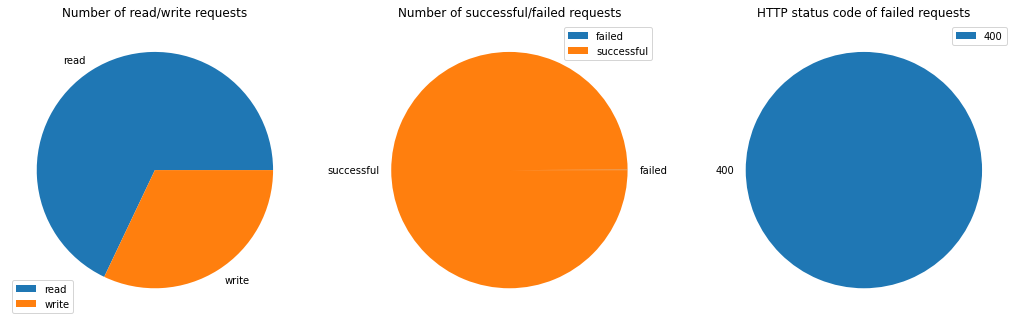

In [6]:
fig = plt.figure(figsize=(18, 6))
# Number of read/write requests
df = requests.groupby(["rw"]).count()["method"]
ax = fig.add_subplot(1, 3, 1)
df.plot(ax=ax, kind="pie", title="Number of read/write requests",
        xlabel="", ylabel="",
        legend=True)
# Number of successful/failed requests
df = requests.groupby(["status"]).count()["method"]
ax = fig.add_subplot(1, 3, 2)
df.plot(ax=ax, kind="pie", title="Number of successful/failed requests",
        xlabel="", ylabel="",
        legend=True)
# HTTP status code of failed requests
df = requests[requests["status"] == "failed"].groupby(["status_code"]).count()["method"]
ax = fig.add_subplot(1, 3, 3)
df.plot(ax=ax, kind="pie", title="HTTP status code of failed requests",
        xlabel="", ylabel="",
        legend=True)

<AxesSubplot:title={'center':'Number of requests of each type'}, ylabel='Requests (count)'>

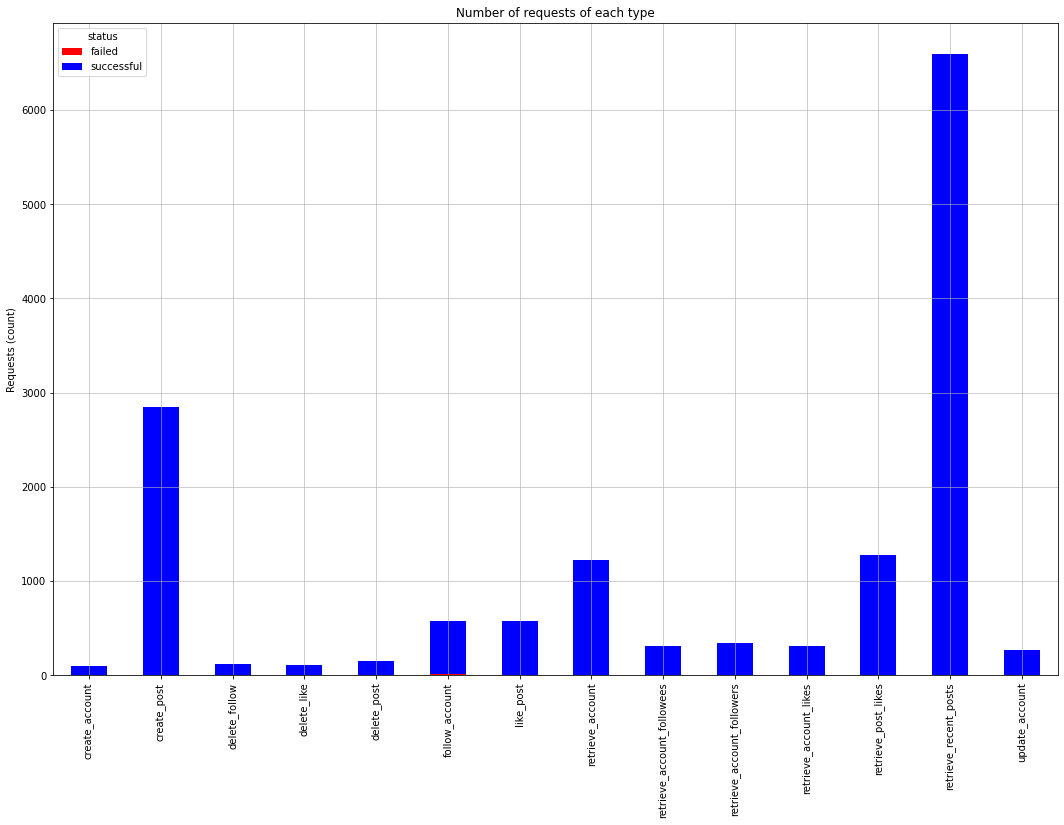

In [7]:
df = requests.groupby(["type", "status"]).count()["method"].unstack().fillna(0)
fig = plt.figure(figsize=(18, 12))
ax = fig.gca()
ax.grid(alpha=0.75)
df.plot(ax=ax, kind="bar", stacked=True, title="Number of requests of each type",
        xlabel="", ylabel="Requests (count)",
        color={"failed": "red", "successful": "blue"}, legend=True,
        grid=True)

### Throughput (1-second window)

<AxesSubplot:title={'center':'Throughput (requests per second)'}, xlabel='Time (seconds)', ylabel='Requests (count)'>

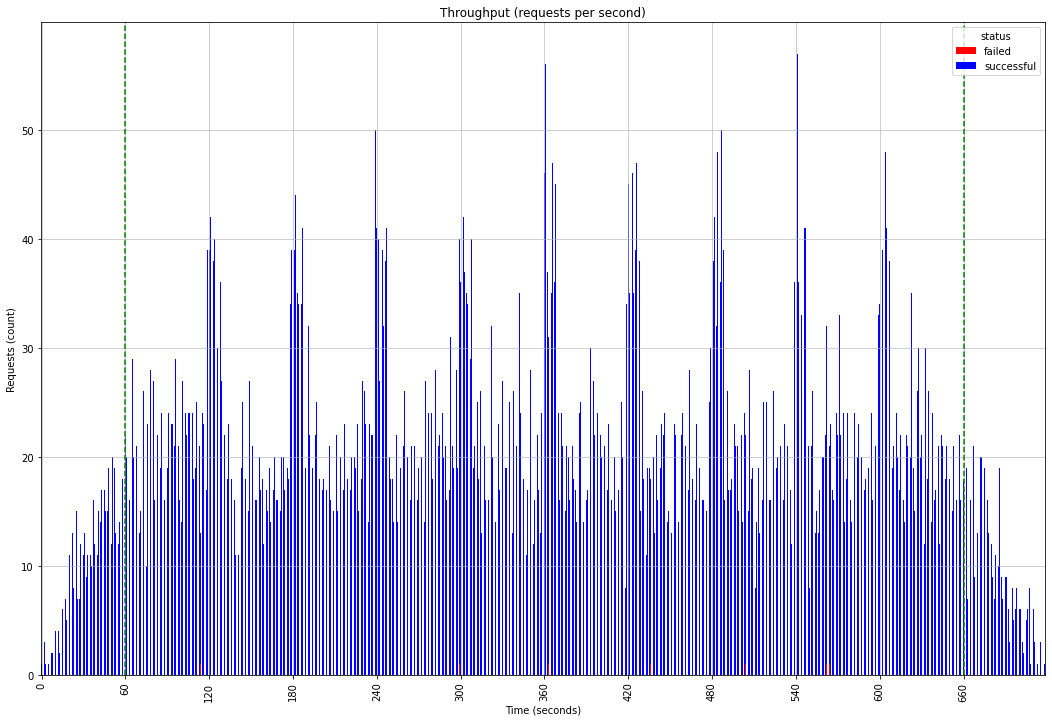

In [8]:
df = requests.groupby(["window", "status"])["window"].count().unstack().fillna(0)
df = df.reindex(range(0, int(df.index.max()) + 1), fill_value=0)
fig = plt.figure(figsize=(18, 12))
ax = fig.gca()
ax.grid(alpha=0.75)
ax.axvline(x=workload_conf["duration"]["ramp_up"],
           ls="--", color="green")
ax.axvline(x=workload_conf["duration"]["total"] - workload_conf["duration"]["ramp_down"],
           ls="--", color="green")
df.plot(ax=ax, kind="bar", stacked=True, title="Throughput (requests per second)",
        xlabel="Time (seconds)", ylabel="Requests (count)",
        color={"failed": "red", "successful": "blue"}, legend=True, grid=True,
        xticks=range(0, int(requests["time"].max()) + 1, 60))

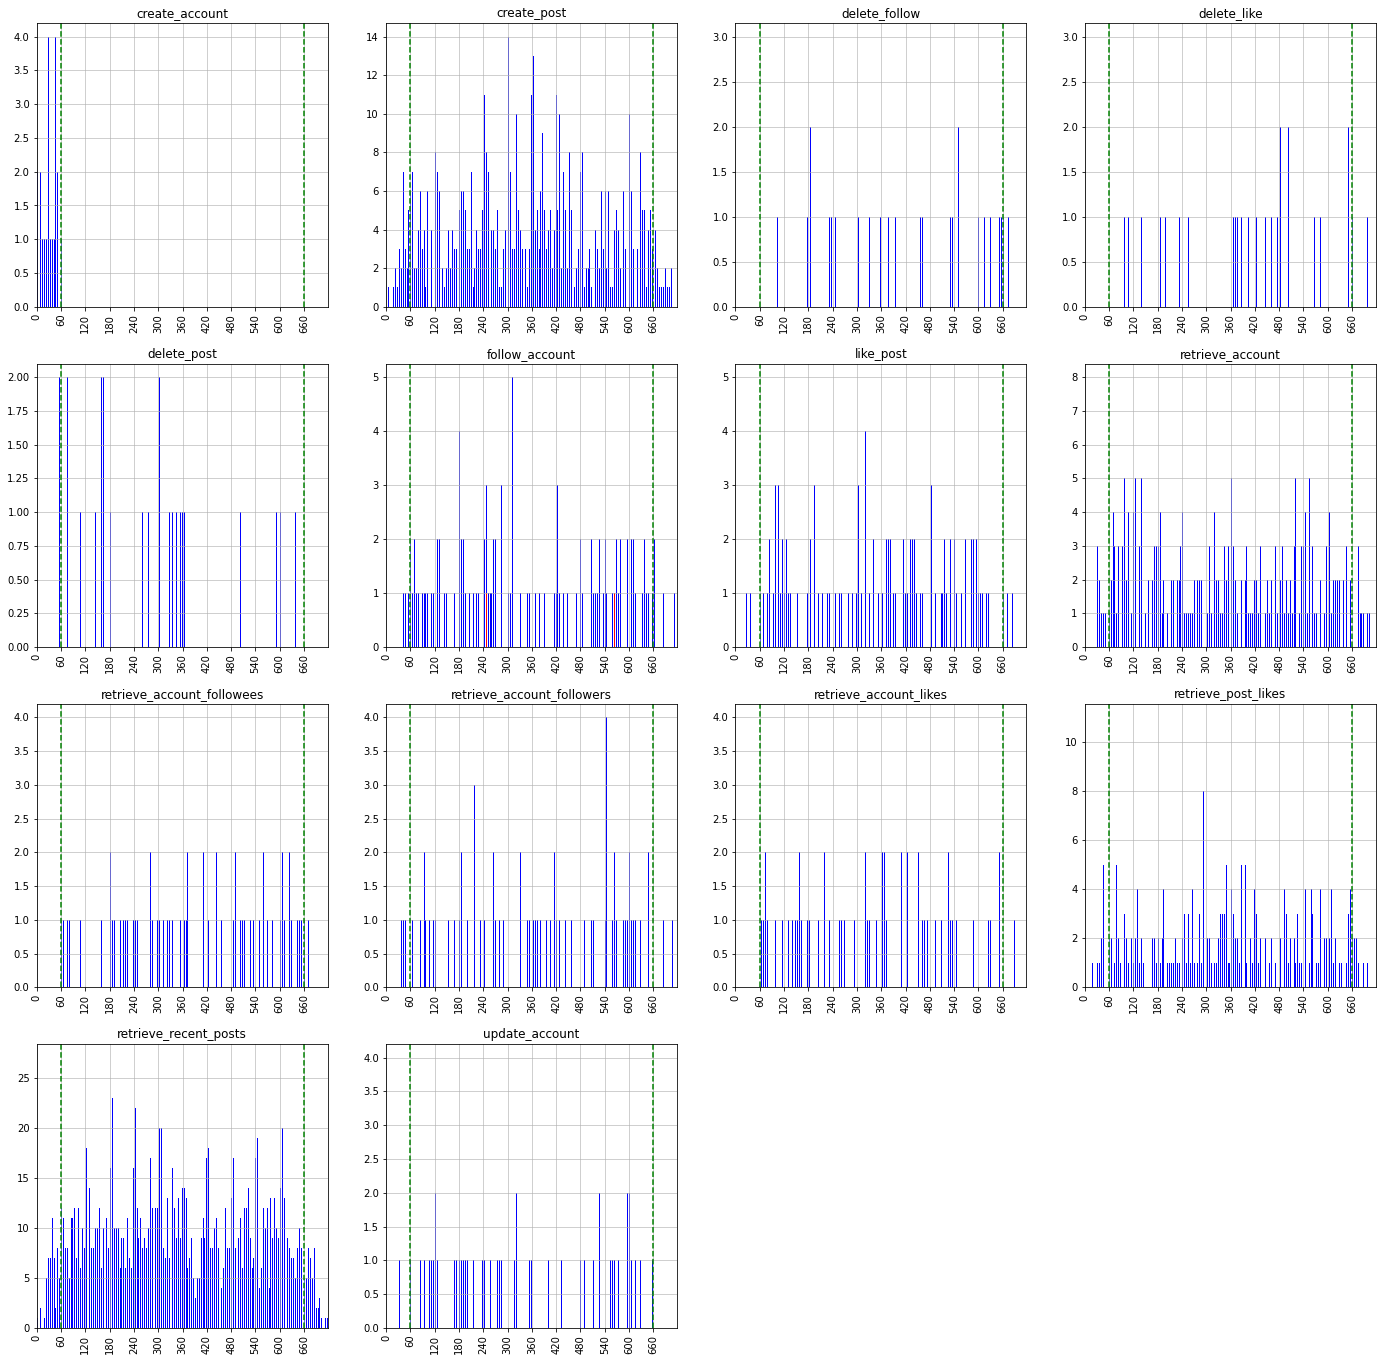

In [9]:
fig = plt.figure(figsize=(24, 24))
for (i, (request_type, _)) in enumerate(requests.groupby(["type"])):
    df = requests[requests["type"] == request_type]
    df = df.groupby(["window", "status"])["window"].count().unstack().fillna(0)
    df = df.reindex(range(0, int(requests["time"].max()) + 1), fill_value=0)
    ax = fig.add_subplot(4, 4, i + 1)
    ax.axvline(x=workload_conf["duration"]["ramp_up"],
               ls="--", color="green")
    ax.axvline(x=workload_conf["duration"]["total"] - workload_conf["duration"]["ramp_down"],
               ls="--", color="green")
    ax.grid(alpha=0.75)
    df.plot(ax=ax, kind="bar", stacked=True, title=request_type,
            xlabel="", ylabel="",
            color={"failed": "red", "successful": "blue"}, legend=False, grid=True,
            xticks=range(0, int(requests["time"].max()) + 1, 60))

### Throughput (fine-grained window)

<AxesSubplot:title={'center':'Throughput (requests per 50 milliseconds)'}, xlabel='Time (seconds)', ylabel='Requests (count)'>

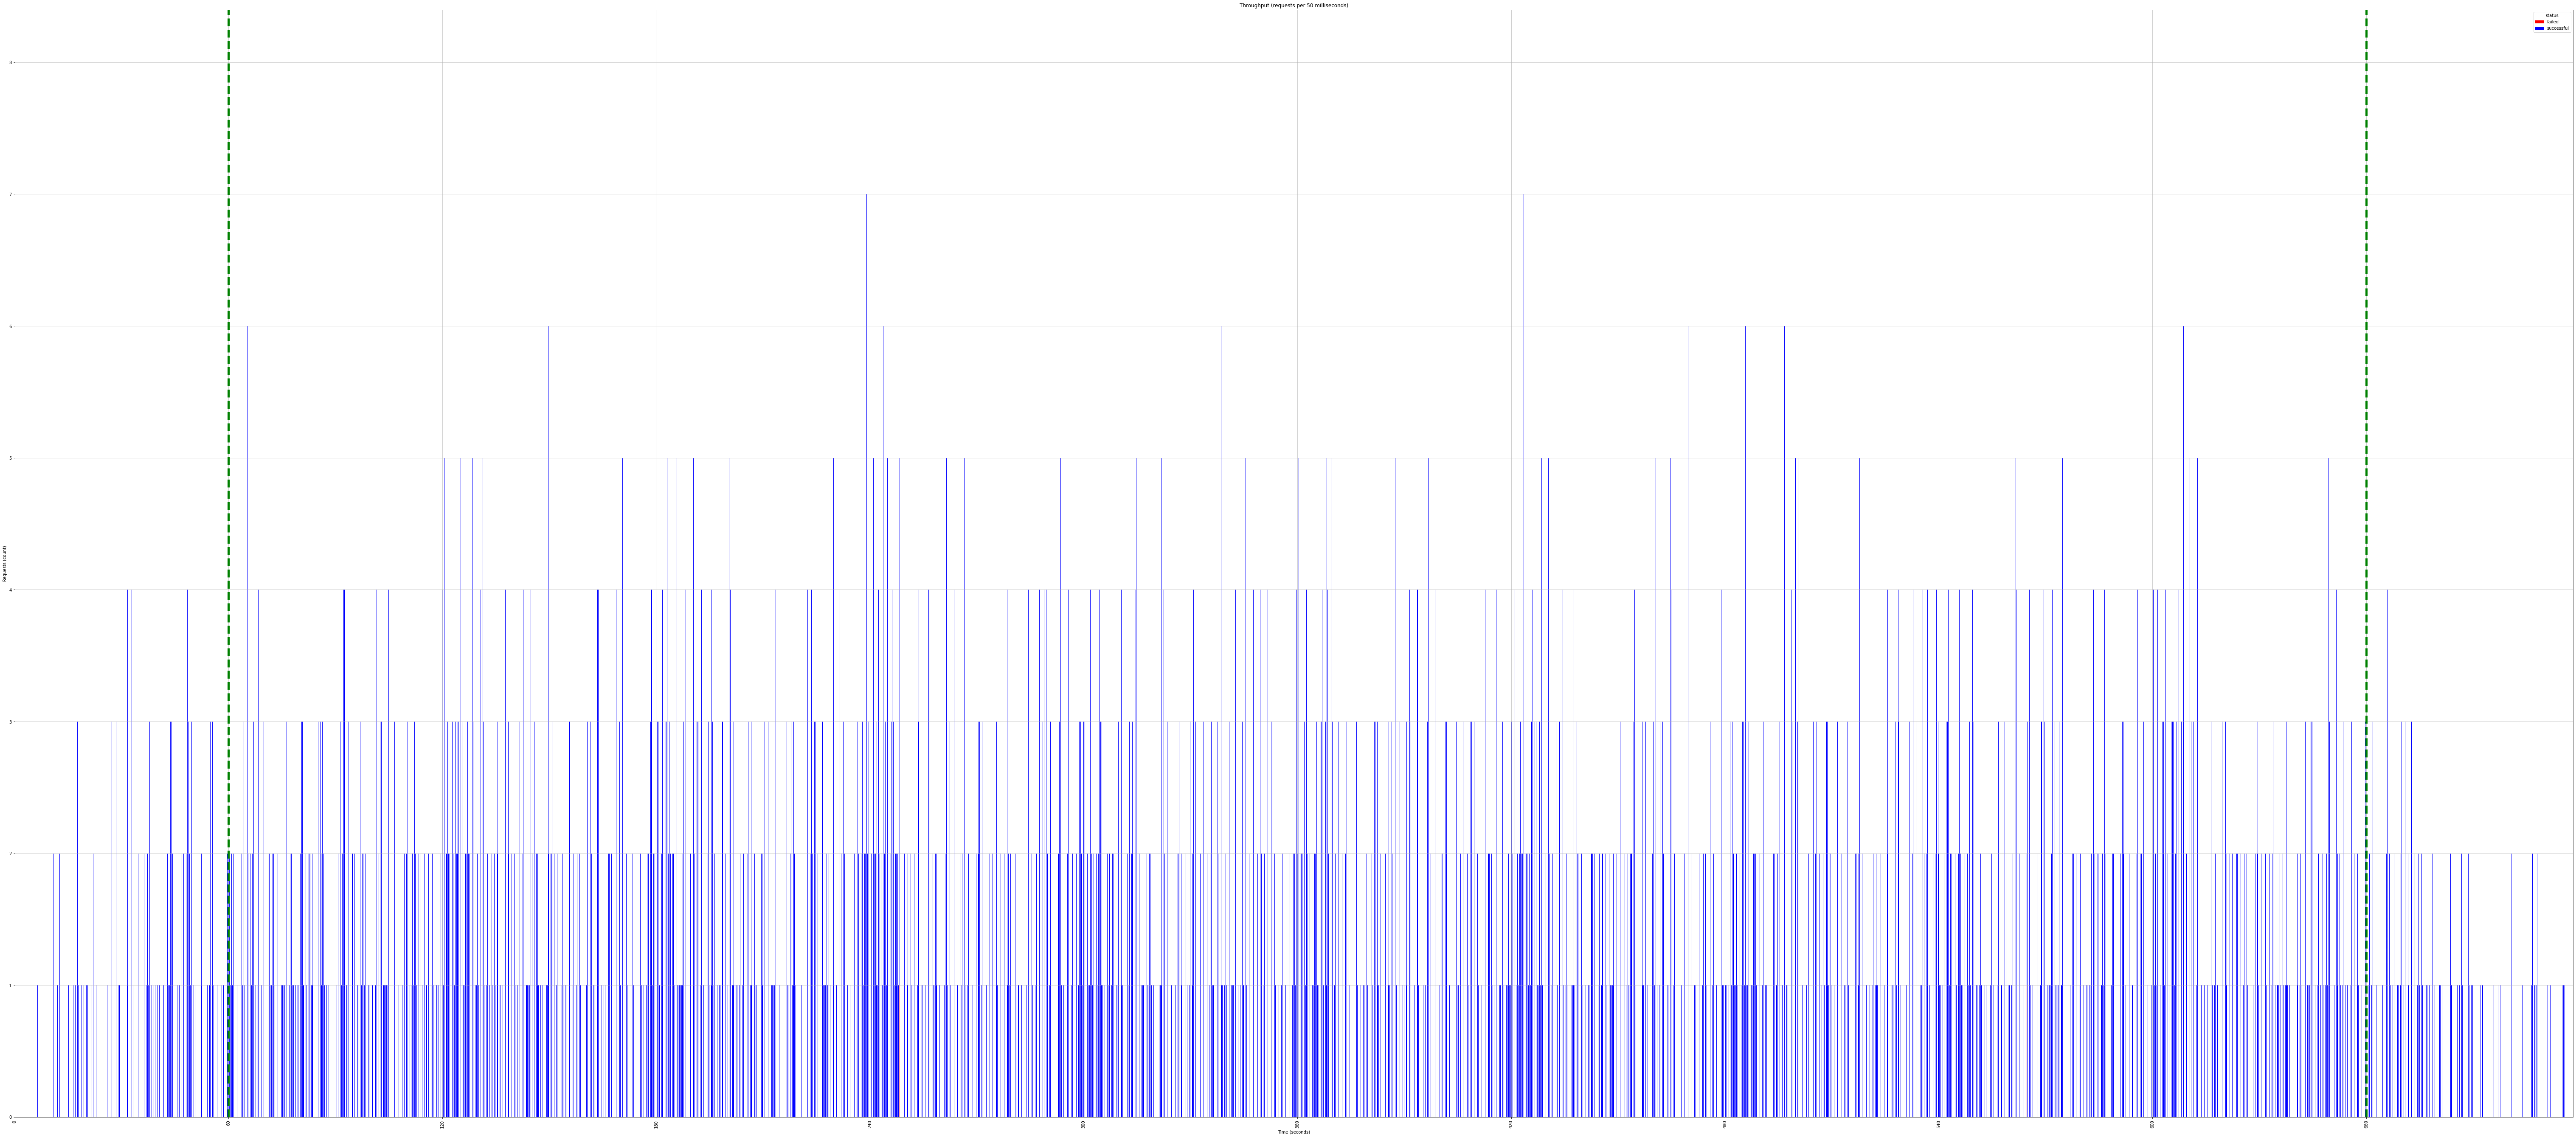

In [10]:
# [CONFIG] Request type or '*' for all
REQUEST_TYPE = '*'

df = requests[requests["type"] == REQUEST_TYPE] if REQUEST_TYPE != '*' else requests
df = df.groupby(["fg_window", "status"])["fg_window"].count().unstack().fillna(0)
df = df.reindex(range(0, int(df.index.max()) + 1), fill_value=0)
fig = plt.figure(figsize=(108, 48))
ax = fig.gca()
ax.grid(alpha=0.75)
ax.axvline(x=(workload_conf["duration"]["ramp_up"] * 1000) // PIT_FG_WINDOW_IN_MS,
           ls="--", linewidth=5, color="green")
ax.axvline(x=((workload_conf["duration"]["total"] - workload_conf["duration"]["ramp_down"])  * 1000) // PIT_FG_WINDOW_IN_MS,
           ls="--", linewidth=5, color="green")
ax.set_xticklabels([str(x * 60) for x in range(0, int(df.index.max()) // (60 * (1000 // PIT_FG_WINDOW_IN_MS)) + 1)])
df.plot(ax=ax, kind="bar", stacked=True,
        title="Throughput (requests per %s milliseconds)" % PIT_FG_WINDOW_IN_MS,
        xlabel="Time (seconds)", ylabel="Requests (count)",
        color={"failed": "red", "successful": "blue"}, legend=True, grid=True,
        xticks=range(0, int(df.index.max()) + 1, 60 * (1000 // PIT_FG_WINDOW_IN_MS)))

### Latency Distribution of Successful Requests Excluding Ramping Periods

<AxesSubplot:title={'center':'Latency Distribution of Successful Requests Excluding Ramping Periods'}, xlabel='Latency (s)', ylabel='Frequency'>

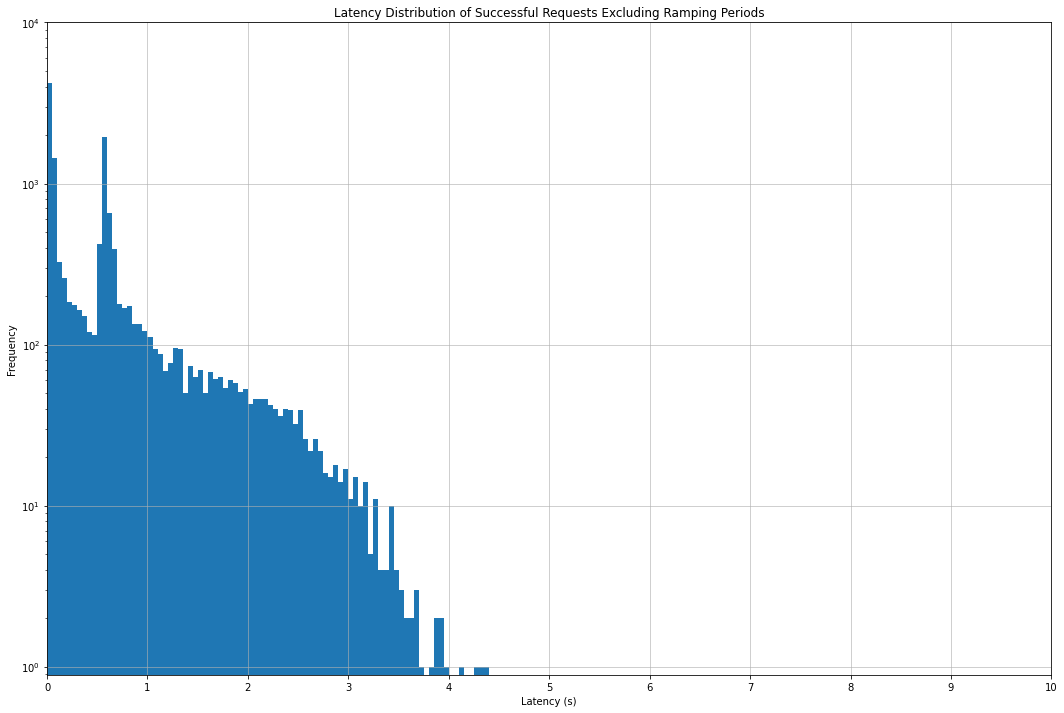

In [11]:
# [CONFIG] Max latency
MAX_LATENCY_IN_S = 10
# [CONFIG] Latency bin size
LATENCY_BIN_IN_MS = 50

df = requests[requests["status"] == "successful"]
df = df[(df["time"] >= workload_conf["duration"]["ramp_up"]) &
        (df["time"] <= workload_conf["duration"]["total"] - workload_conf["duration"]["ramp_down"])]
df["latency_bin"] = df.apply(lambda r: int(r["latency"] * 1000 // LATENCY_BIN_IN_MS), axis=1)
fig = plt.figure(figsize=(18, 12))
ax = fig.gca(xlabel="Latency (s)", ylabel="Requests (count)")
ax.grid(alpha=0.75)
ax.set_yscale("log")
ax.set_xlim((0, (1000 // LATENCY_BIN_IN_MS) * MAX_LATENCY_IN_S))
ax.set_ylim((0, 10000))
ax.set_xticks(range(0, (1000 // LATENCY_BIN_IN_MS) * MAX_LATENCY_IN_S + 1, (1000 // LATENCY_BIN_IN_MS)))
ax.set_xticklabels([str(s) for s in range(MAX_LATENCY_IN_S + 1)])
df["latency_bin"].plot(ax=ax, kind="hist",
                       title="Latency Distribution of Successful Requests Excluding Ramping Periods",
                       bins=range((1000 // LATENCY_BIN_IN_MS) * MAX_LATENCY_IN_S), grid=True)

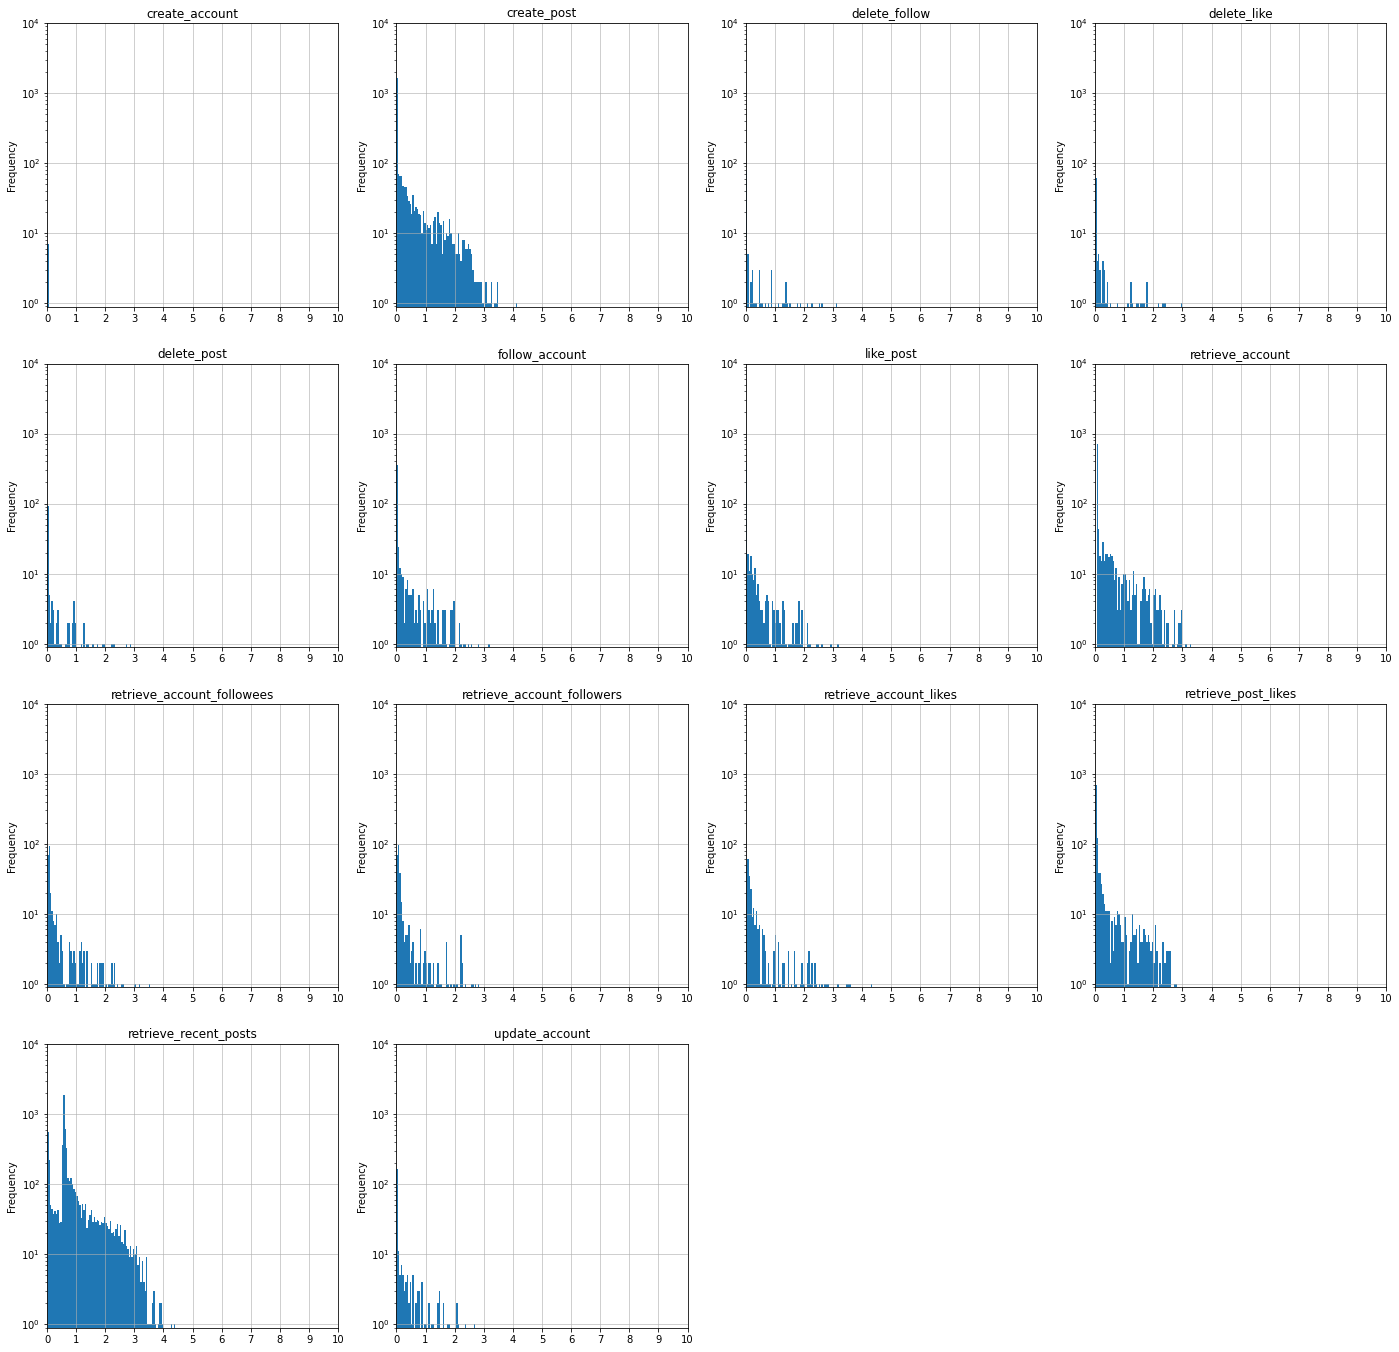

In [12]:
fig = plt.figure(figsize=(24, 24))
for (i, (request_type, _)) in enumerate(requests.groupby(["type"])):
    df = requests[(requests["status"] == "successful") & (requests["type"] == request_type)]
    df = df[(df["time"] >= workload_conf["duration"]["ramp_up"]) &
            (df["time"] <= workload_conf["duration"]["total"] - workload_conf["duration"]["ramp_down"])]
    df["latency_bin"] = df.apply(lambda r: int(r["latency"] * 1000 // LATENCY_BIN_IN_MS), axis=1)
    ax = fig.add_subplot(4, 4, i + 1)
    ax.grid(alpha=0.75)
    ax.set_yscale("log")
    ax.set_xlim((0, (1000 // LATENCY_BIN_IN_MS) * MAX_LATENCY_IN_S))
    ax.set_ylim((0, 10000))
    ax.set_xticks(range(0, (1000 // LATENCY_BIN_IN_MS) * MAX_LATENCY_IN_S + 1, (1000 // LATENCY_BIN_IN_MS)))
    ax.set_xticklabels([str(s) for s in range(MAX_LATENCY_IN_S + 1)])
    df["latency_bin"].plot(ax=ax, kind="hist", title=request_type,
                           xlabel="", ylabel="",
                           bins=range((1000 // LATENCY_BIN_IN_MS) * MAX_LATENCY_IN_S), grid=True)

### PIT Latency of Successful Requests (1-second window)

<AxesSubplot:title={'center':'PIT Latency of Successful Requests (1-second window)'}, xlabel='Time (seconds)', ylabel='Latency (seconds)'>

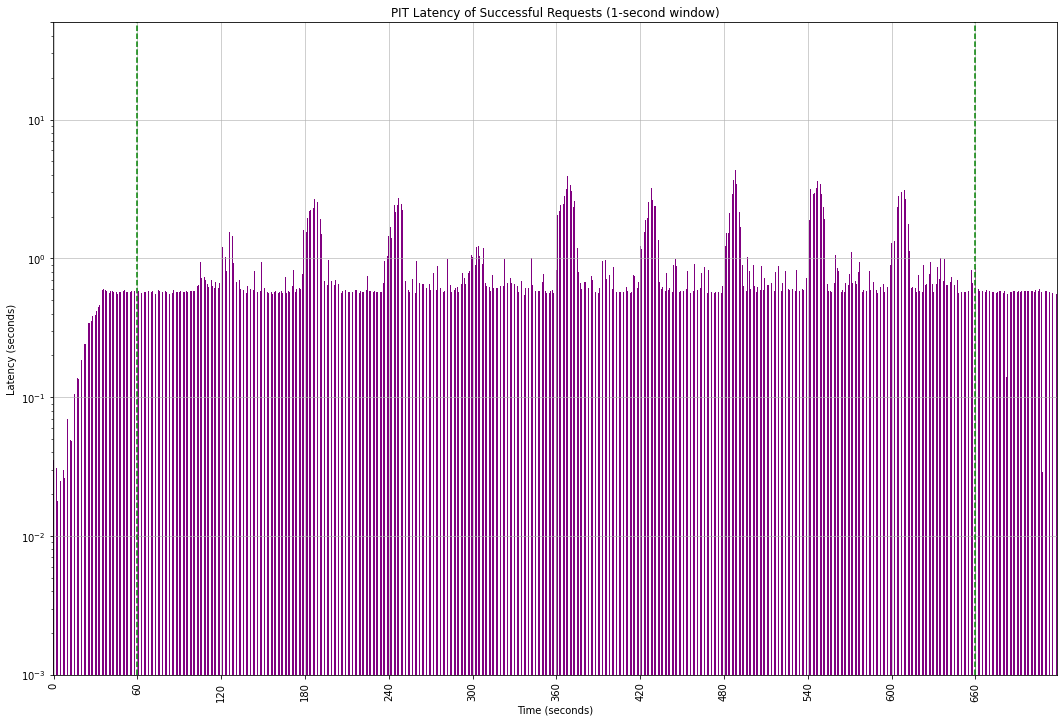

In [13]:
df = requests[requests["status"] == "successful"]
df = df.groupby(["window"])["latency"].agg(PIT_AGGREGATE_FUNC)
df = df.reindex(range(0, int(df.index.max()) + 1), fill_value=0)
fig = plt.figure(figsize=(18, 12))
ax = fig.gca()
ax.axvline(x=workload_conf["duration"]["ramp_up"],
           ls="--", color="green")
ax.axvline(x=workload_conf["duration"]["total"] - workload_conf["duration"]["ramp_down"],
           ls="--", color="green")
ax.grid(alpha=0.75)
df.plot(ax=ax, kind="bar", title="PIT Latency of Successful Requests (1-second window)",
        xlabel="Time (seconds)", ylabel="Latency (seconds)",
        color="purple", logy=True, grid=True,
        xticks=range(0, int(df.index.max()) + 1, 60),
        yticks=[0.001, 0.010, 0.100, 1.0, 10.0, 50.0])

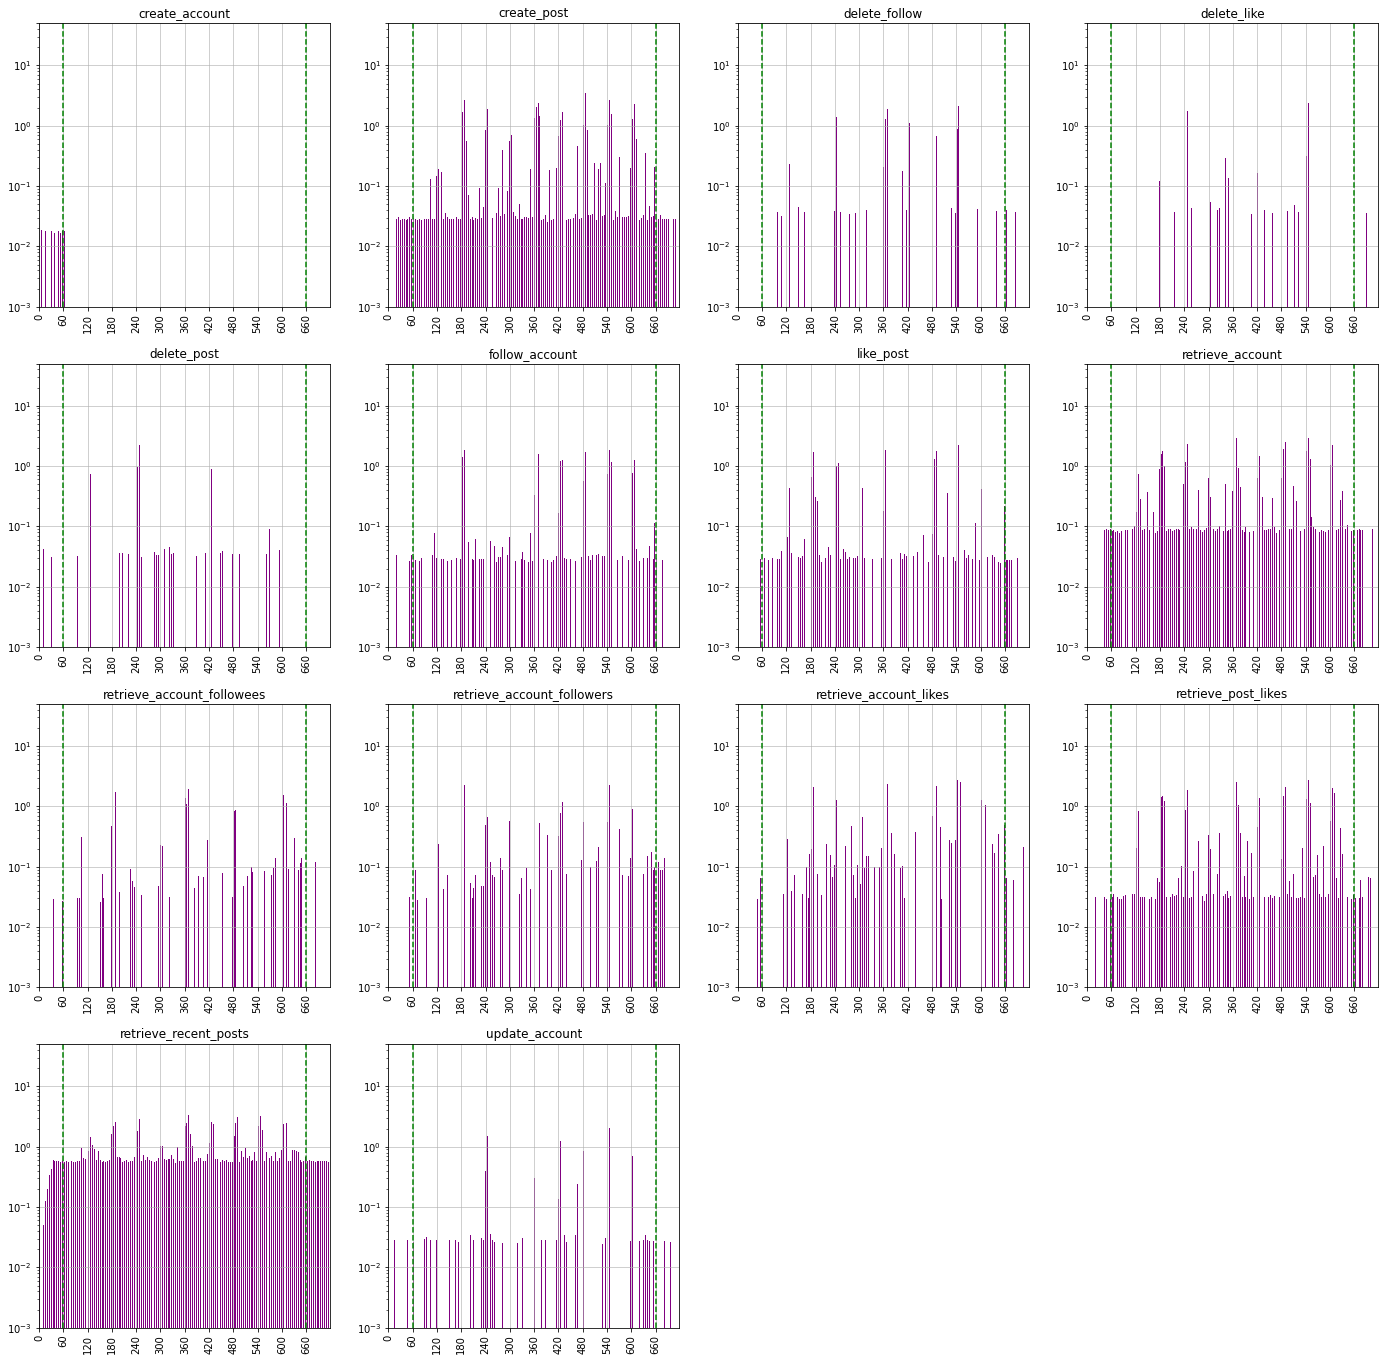

In [14]:
fig = plt.figure(figsize=(24, 24))
for (i, (request_type, _)) in enumerate(requests.groupby(["type"])):
    df = requests[(requests["status"] == "successful") & (requests["type"] == request_type)]
    df = df.groupby(["window"])["latency"].agg(PIT_AGGREGATE_FUNC)
    df = df.reindex(range(0, int(requests["time"].max()) + 1), fill_value=0)
    ax = fig.add_subplot(4, 4, i + 1)
    ax.axvline(x=workload_conf["duration"]["ramp_up"],
               ls="--", color="green")
    ax.axvline(x=workload_conf["duration"]["total"] - workload_conf["duration"]["ramp_down"],
               ls="--", color="green")
    ax.grid(alpha=0.75)
    df.plot(ax=ax, kind="bar", title=request_type,
            xlabel="", ylabel="",
            color="purple", logy=True, grid=True,
            xticks=range(0, int(requests["time"].max()) + 1, 60),
            yticks=[0.001, 0.010, 0.100, 1.0, 10.0, 50.0])

### PIT Latency of Successful Requests (fine-grained window)

<AxesSubplot:title={'center':'PIT Latency of Successful Requests (50-millisecond window)'}, xlabel='Time (seconds)', ylabel='Latency (seconds)'>

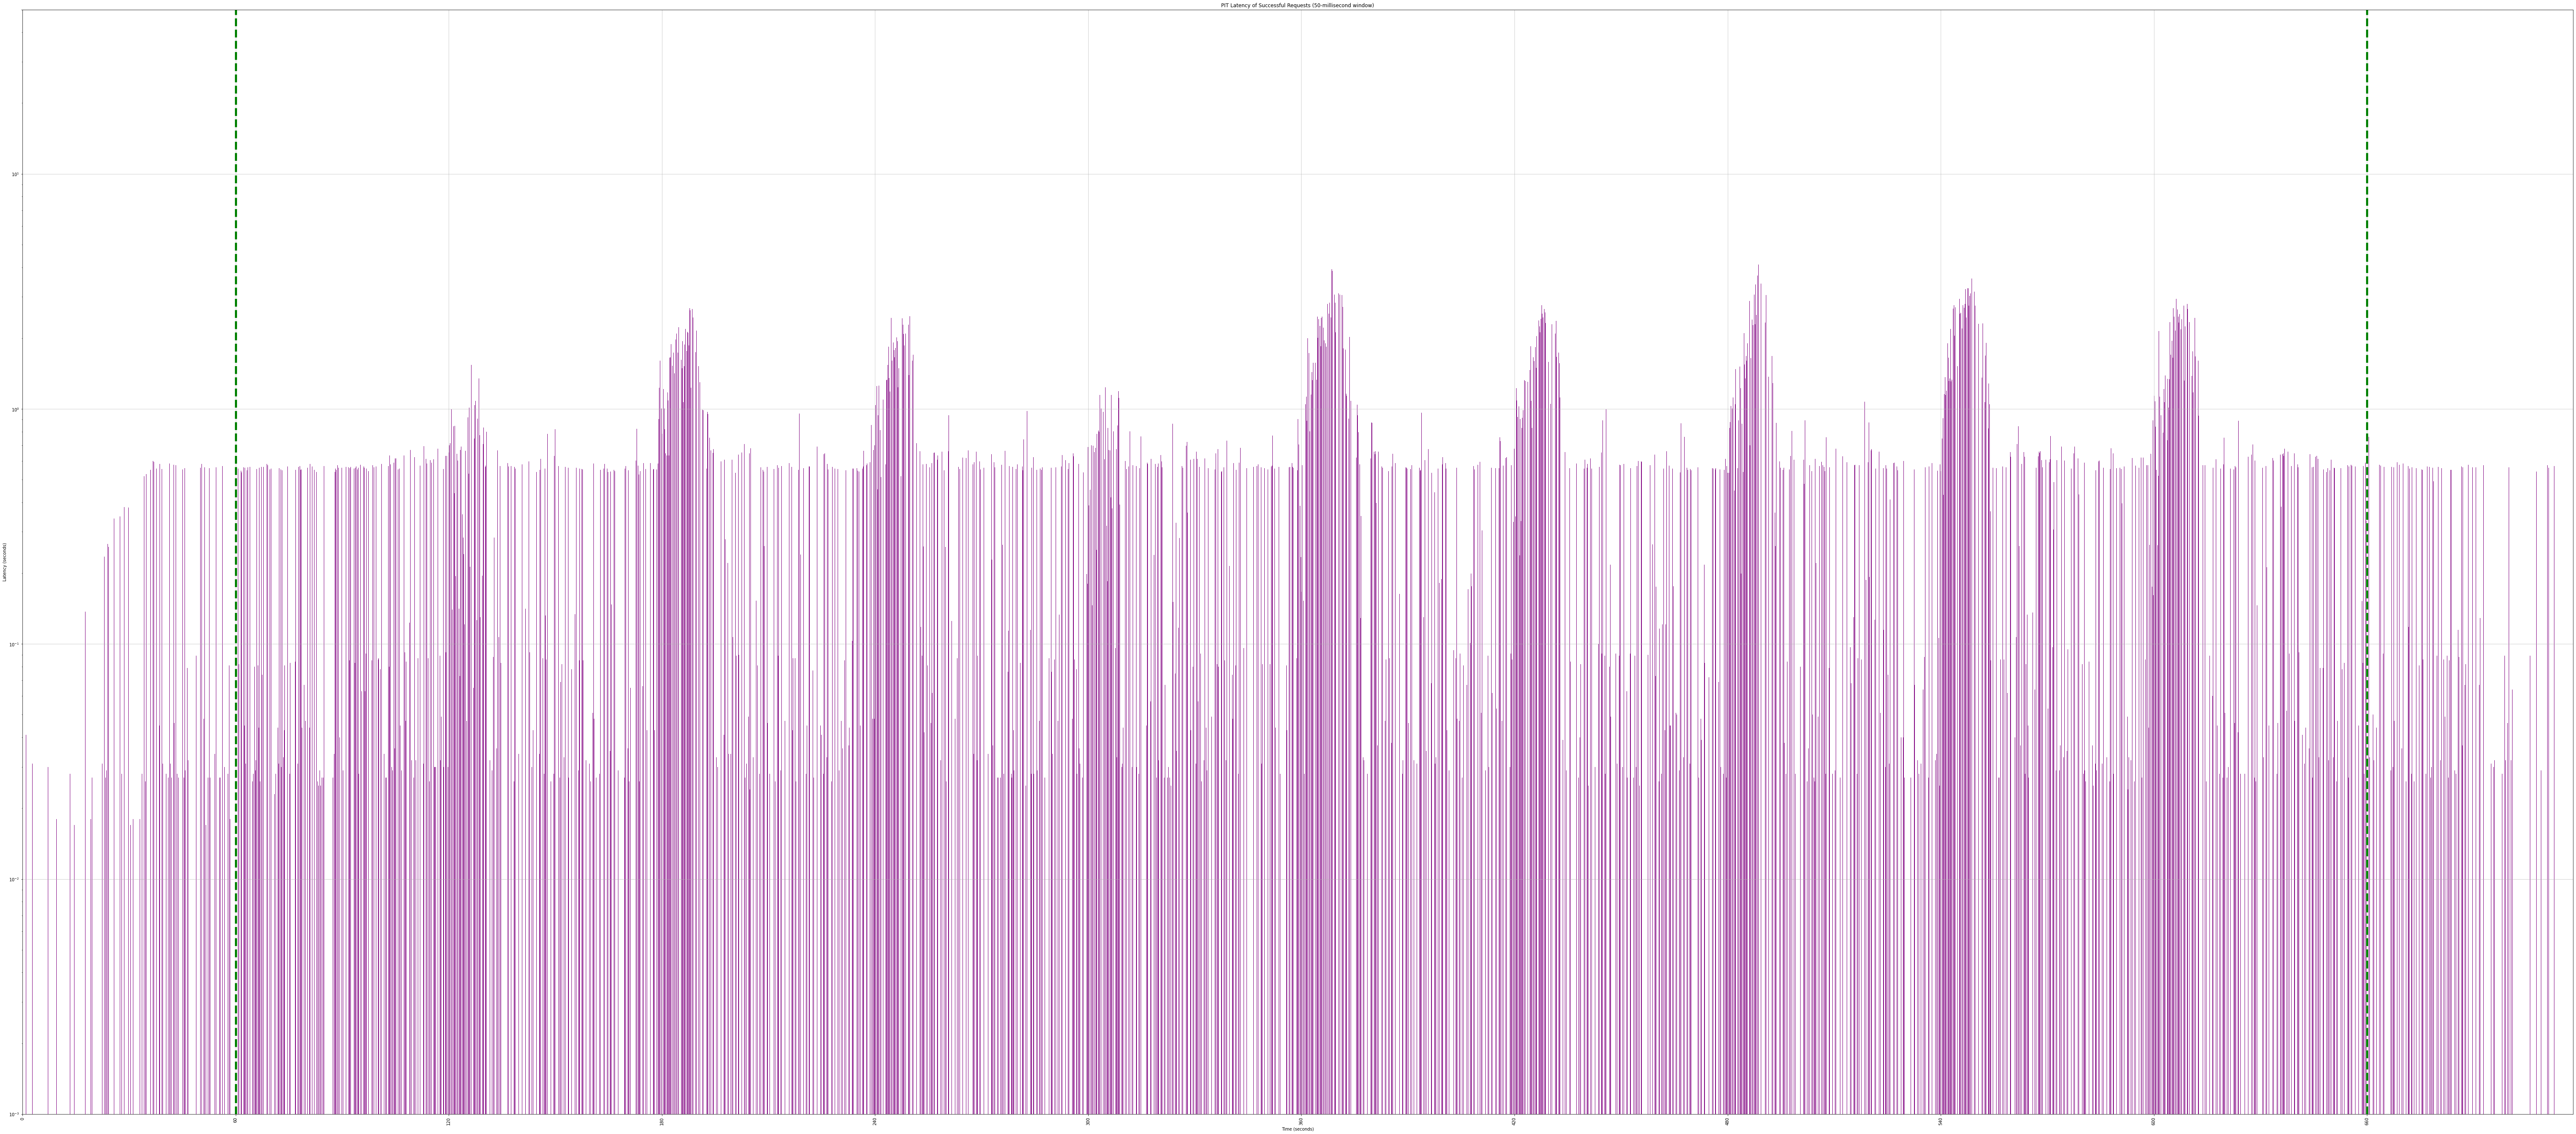

In [15]:
# [CONFIG] Request type or '*' for all
REQUEST_TYPE = '*'

df = requests[requests["type"] == REQUEST_TYPE] if REQUEST_TYPE != '*' else requests
df = df[requests["status"] == "successful"]
df = df.groupby(["fg_window"])["latency"].agg(PIT_AGGREGATE_FUNC)
df = df.reindex(range(0, int(df.index.max()) + 1), fill_value=0)
fig = plt.figure(figsize=(108, 48))
ax = fig.gca()
ax.grid(alpha=0.75)
ax.axvline(x=(workload_conf["duration"]["ramp_up"] * 1000) // PIT_FG_WINDOW_IN_MS,
           ls="--", linewidth=5, color="green")
ax.axvline(x=((workload_conf["duration"]["total"] - workload_conf["duration"]["ramp_down"])  * 1000) // PIT_FG_WINDOW_IN_MS,
           ls="--", linewidth=5, color="green")
ax.set_xticklabels([str(x * 60) for x in range(0, int(df.index.max()) // (60 * (1000 // PIT_FG_WINDOW_IN_MS)) + 1)])
df.plot(ax=ax, kind="bar",
        title="PIT Latency of Successful Requests (%s-millisecond window)" % PIT_FG_WINDOW_IN_MS,
        xlabel="Time (seconds)", ylabel="Latency (seconds)",
        color="purple", logy=True, grid=True,
        xticks=range(0, int(df.index.max()) + 1, 60 * (1000 // PIT_FG_WINDOW_IN_MS)),
        yticks=[0.001, 0.010, 0.100, 1.0, 10.0, 50.0])

## System Event Monitoring Logs

In [16]:
# Parse tcplife logs
conn_to = []
for node_hostname in os.listdir(os.path.join(EXPERIMENT_DIR, "logs")):
    if os.path.isfile(os.path.join(EXPERIMENT_DIR, "logs", node_hostname, "tcplife-bpfcc.tar.gz")):
        tarball = tarfile.open(os.path.join(EXPERIMENT_DIR, "logs", node_hostname, "tcplife-bpfcc.tar.gz"))
        with tarball.extractfile("./tcplife-bpfcc.log") as tcplife_log_file:
            reader = csv.DictReader(codecs.getreader("utf-8")(tcplife_log_file))
            for row in reader:
                if row["COMM"] in ("uwsgi", "nginx", "postgres", "account_server", "follow_server", "like_server", "post_server", "uniquepair_serv"):
                    conn_to.append({
                        "time": float(row["TIME(s)"]),
                        "comm": row["COMM"],
                        "addr": row["RADDR"],
                        "port": row["RPORT"],
                        "duration": float(row["MS"])
                    })

In [17]:
# Build data frame
conn_to = pd.DataFrame(conn_to)
conn_to["fg_window"] = conn_to.apply(lambda r: range(int(r["time"] * 1000) // TCPLIFE_FG_WINDOW_IN_MS, int((r["time"] + r["duration"] / 1000) * 1000) // TCPLIFE_FG_WINDOW_IN_MS + 1), axis=1)
conn_to = conn_to.explode("fg_window")

### API Gateway (fine-grained Window)

<AxesSubplot:title={'center':'API Gateway - Number of requests being processed (25-millisecond window)'}, xlabel='Time', ylabel='Requests (count)'>

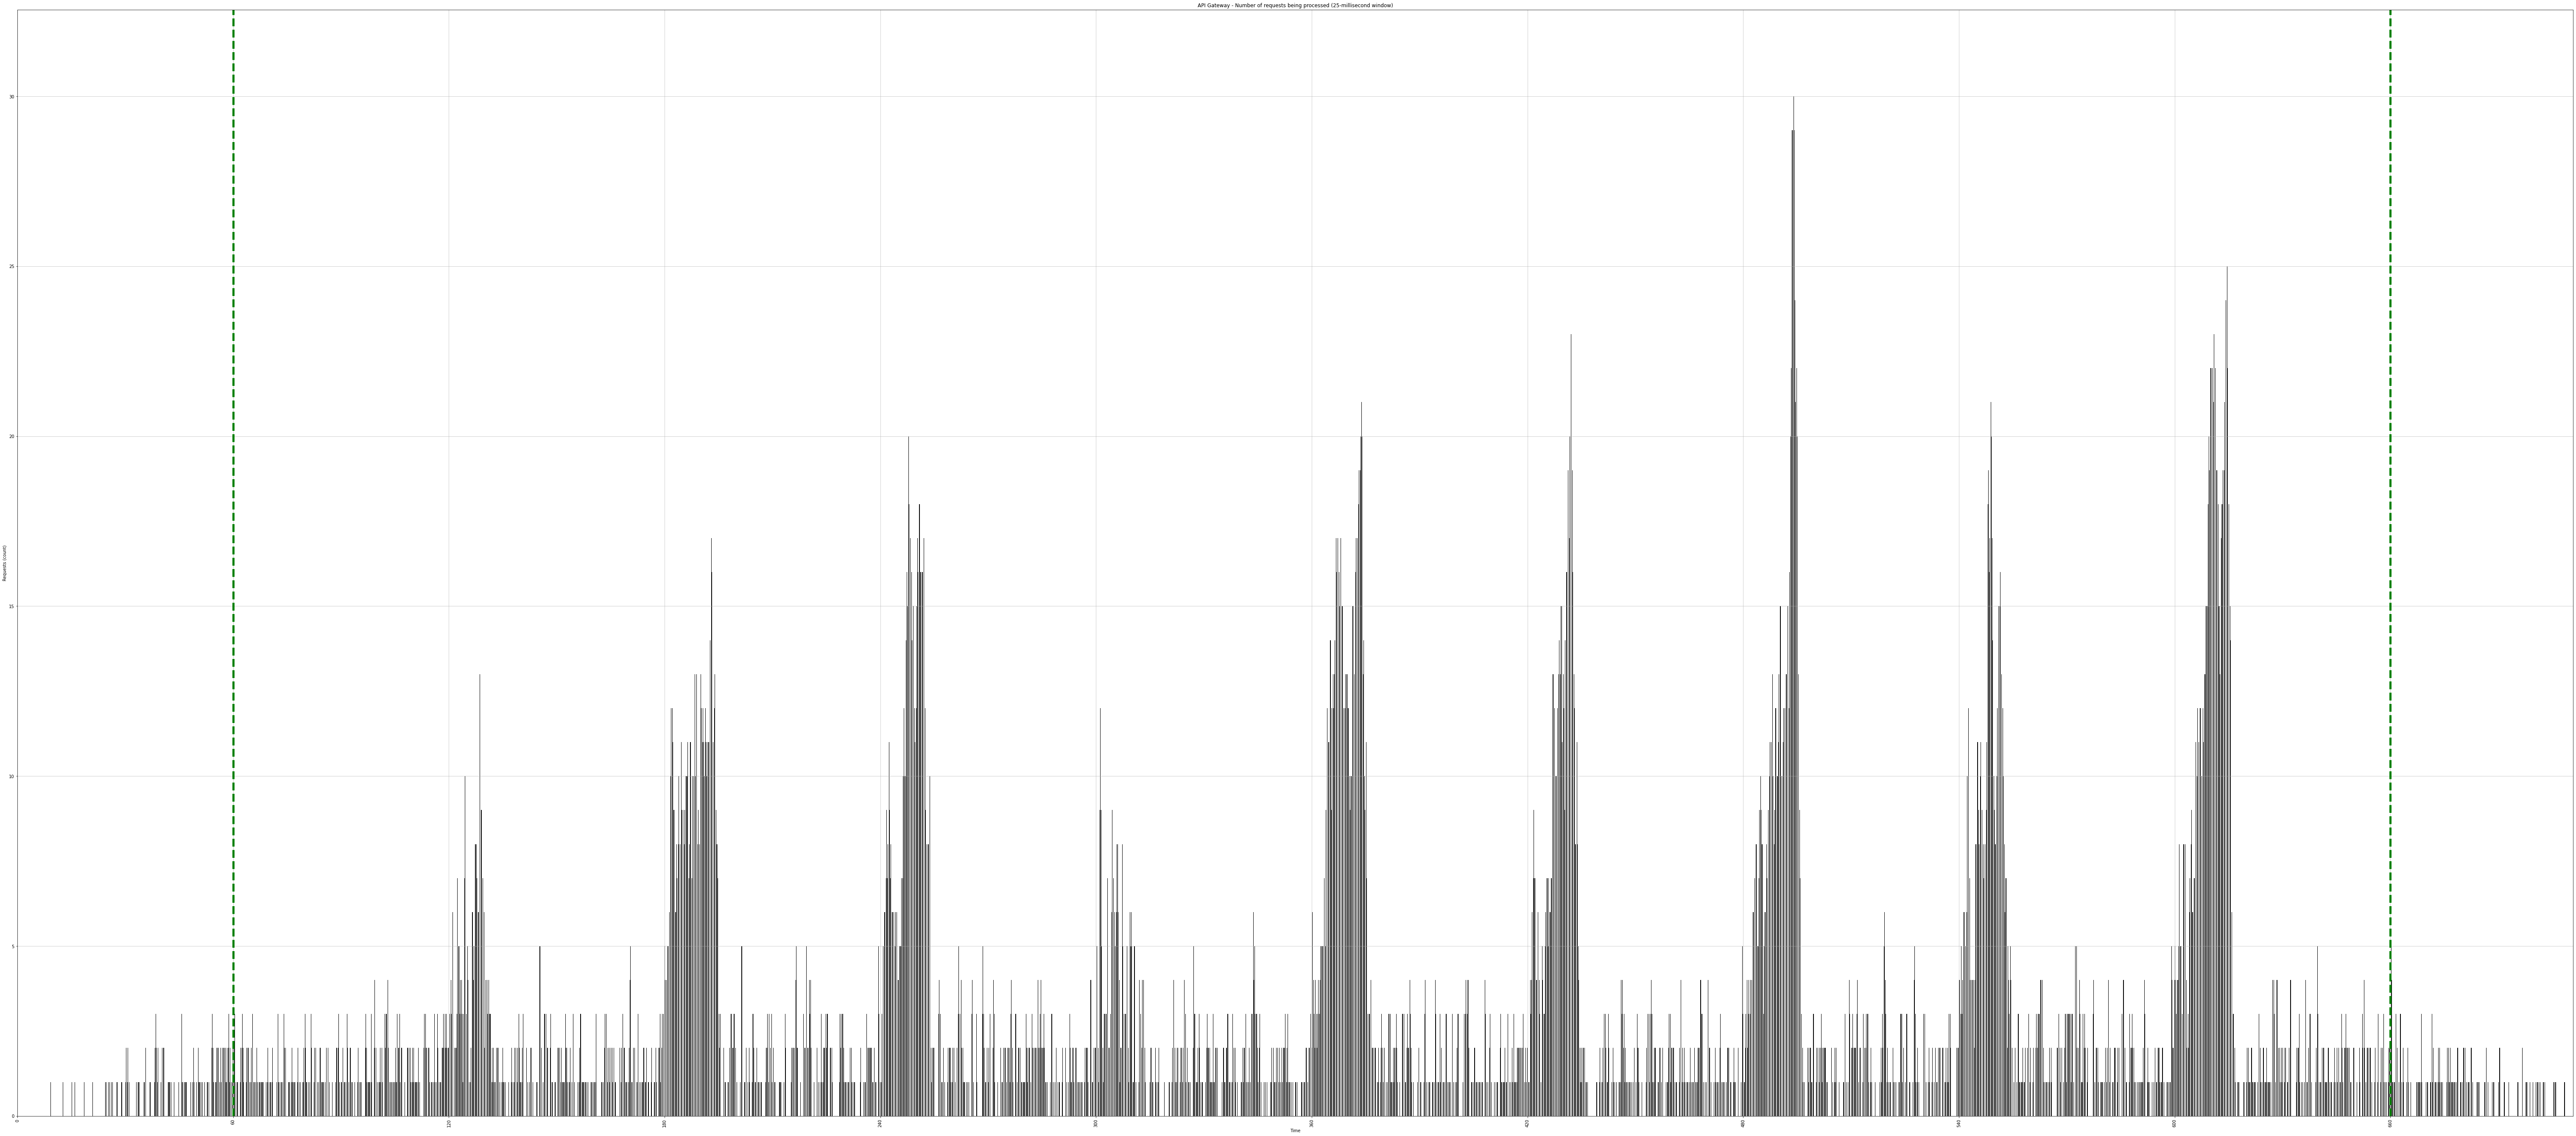

In [18]:
# [TODO] Get ports from configuration file

df = conn_to
df = df[df["port"] == "8080"]
df = df.groupby(["fg_window"])["fg_window"].count()
df = df.reindex(range(0, int(df.index.max()) + 1), fill_value=0)
fig = plt.figure(figsize=(108, 48))
ax = fig.gca()
ax.grid(alpha=0.75)
ax.axvline(x=(workload_conf["duration"]["ramp_up"] * 1000) // TCPLIFE_FG_WINDOW_IN_MS,
           ls="--", linewidth=5, color="green")
ax.axvline(x=((workload_conf["duration"]["total"] - workload_conf["duration"]["ramp_down"])  * 1000) // TCPLIFE_FG_WINDOW_IN_MS,
           ls="--", linewidth=5, color="green")
ax.set_xticklabels([str(x * 60) for x in range(0, int(df.index.max()) // (60 * (1000 // TCPLIFE_FG_WINDOW_IN_MS)) + 1)])
df.plot(ax=ax, kind="bar",
        title="API Gateway - Number of requests being processed (%s-millisecond window)" % TCPLIFE_FG_WINDOW_IN_MS,
        xlabel="Time", ylabel="Requests (count)",
        color="black", grid=True,
        xticks=range(0, int(df.index.max()) + 1, 60 * (1000 // TCPLIFE_FG_WINDOW_IN_MS)))

## Experiment Configuration

### System Configuration File

In [19]:
print(yaml.dump(system_conf))

pc701.emulab.net:
  containers:
    account_service:
      image: rodrigoalveslima/buzzblog:account_latest
      logs:
      - /tmp/calls.log
      options:
        detach: ''
        env:
        - port=9090
        - threads=8
        - backend_filepath=/etc/opt/BuzzBlogApp/backend.yml
        - postgres_user=postgres
        - postgres_password=postgres
        - postgres_dbname=postgres
        name: account_service
        publish: 9090:9090
        volume: /etc/opt/BuzzBlogApp:/etc/opt/BuzzBlogApp
      start_order: 2
  kernel:
    net.core.somaxconn: 128
    net.ipv4.ip_local_port_range: 32768 65535
    net.ipv4.tcp_abort_on_overflow: 1
    net.ipv4.tcp_tw_reuse: 1
  monitors:
    collectl:
      dirpath: /tmp/collectl
      niceness: 19
      options:
        filename: /tmp/collectl/coll
        interval: '0.05'
        options: Tm
        plot: ''
        subsys: CDM
    radvisor:
      command: radvisor run docker
      dirpath: /tmp/radvisor
      niceness: 19
      options:

### Workload Configuration File

In [20]:
print(yaml.dump(workload_conf))

duration:
  ramp_down: 60
  ramp_up: 60
  total: 720
request_graph:
  create_account:
    create_post: 0.5
    retrieve_recent_posts: 0.5
  create_post:
    retrieve_recent_posts: 1.0
  delete_follow:
    create_post: 0.5
    retrieve_recent_posts: 0.5
  delete_like:
    create_post: 0.5
    retrieve_recent_posts: 0.5
  delete_post:
    create_post: 0.5
    retrieve_recent_posts: 0.5
  follow_account:
    create_post: 0.5
    retrieve_recent_posts: 0.5
  like_post:
    create_post: 0.5
    retrieve_recent_posts: 0.5
  main:
    create_account: 1.0
  retrieve_account:
    retrieve_account_followees: 0.25
    retrieve_account_followers: 0.25
    retrieve_account_likes: 0.25
    retrieve_account_posts: 0.25
  retrieve_account_followees:
    create_post: 0.5
    retrieve_recent_posts: 0.5
  retrieve_account_followers:
    create_post: 0.5
    retrieve_recent_posts: 0.5
  retrieve_account_likes:
    create_post: 0.5
    retrieve_recent_posts: 0.5
  retrieve_account_posts:
    create_post: 0

In [3]:
import perfProcess

perfProcess.run(EXPERIMENT_DIR)

PART 1 DONE for node pc794.emulab.net


PART 1 DONE for node pc796.emulab.net




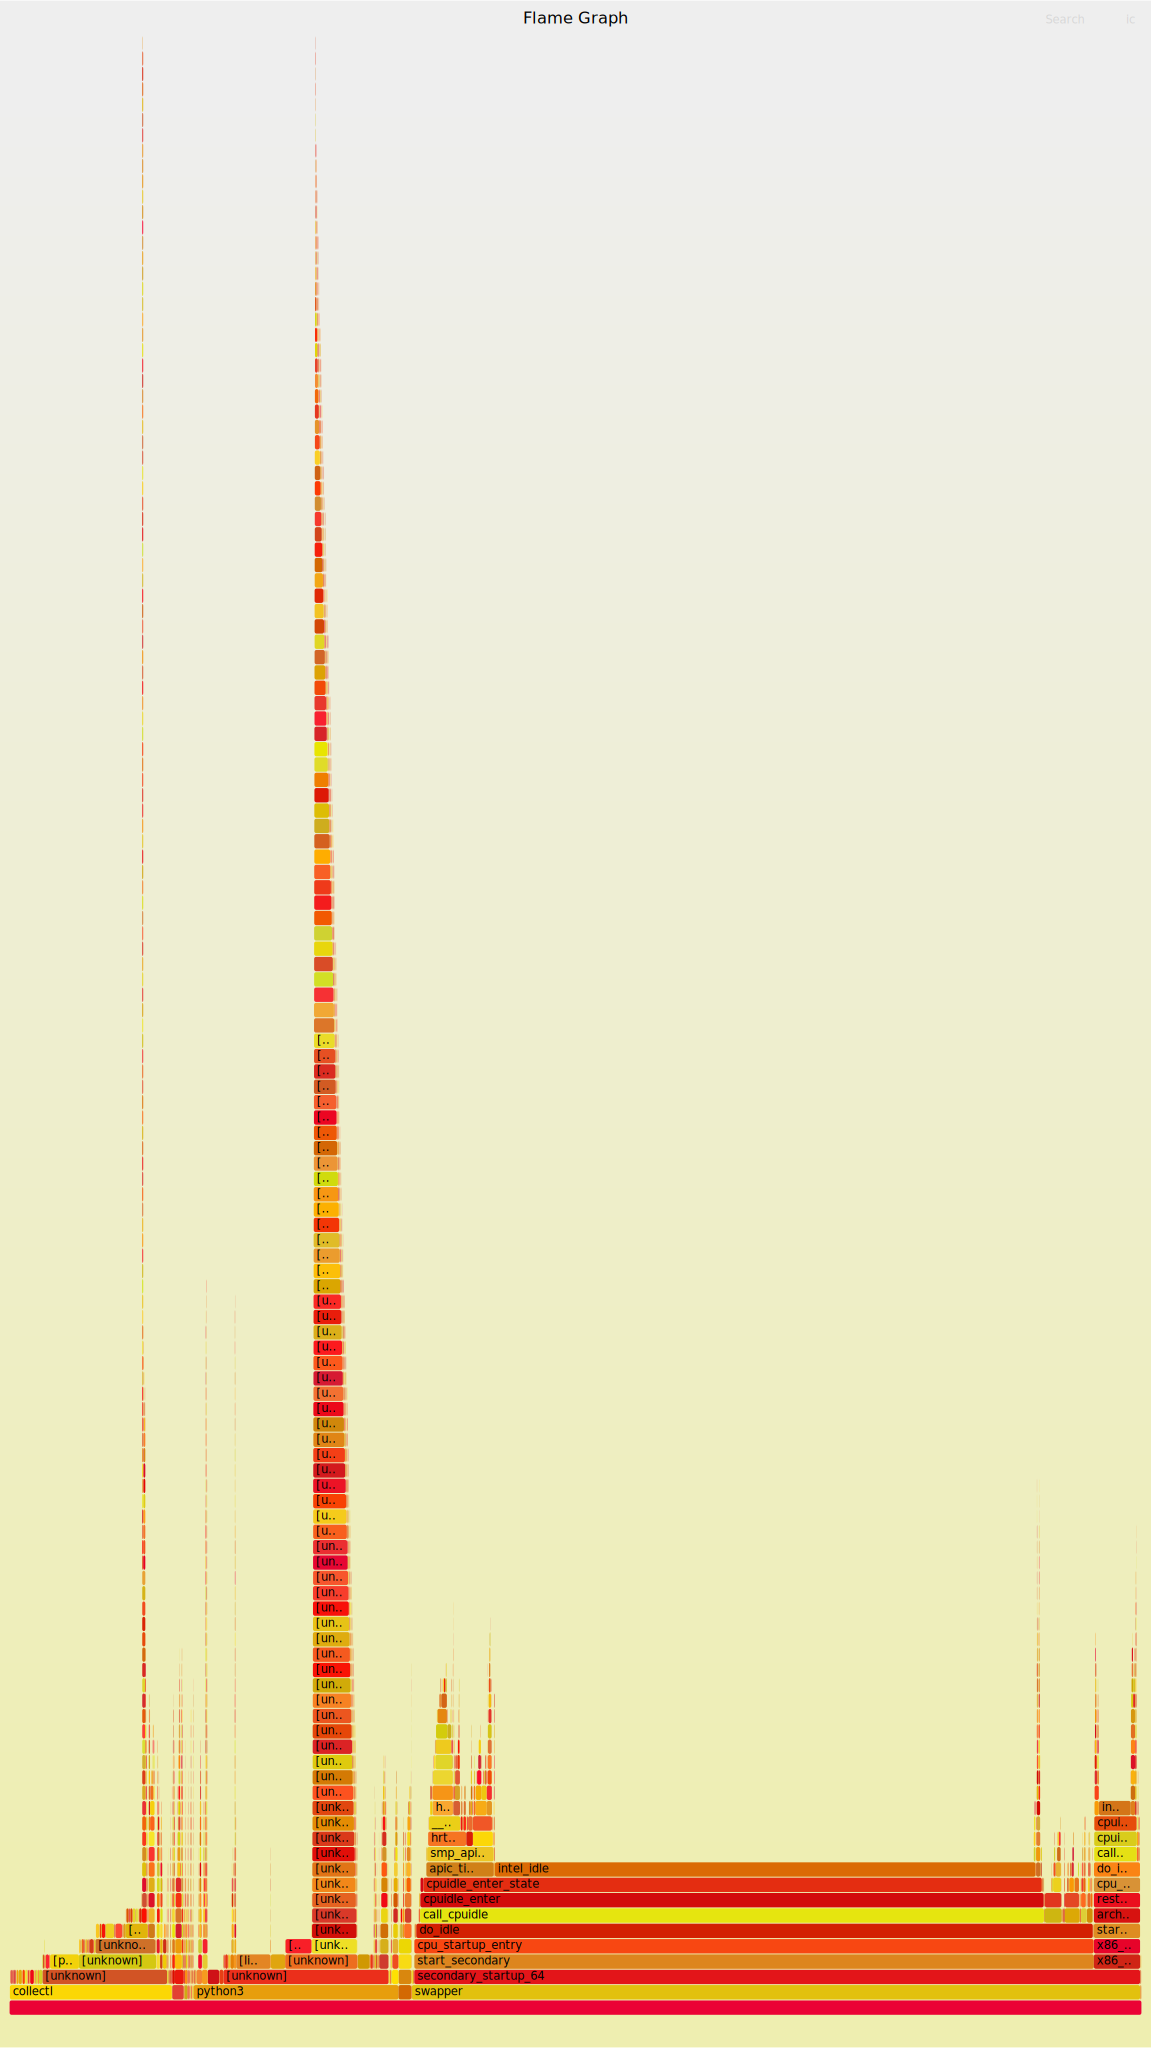



 FLAME GRAPH FOR NODE pc794.emulab.net




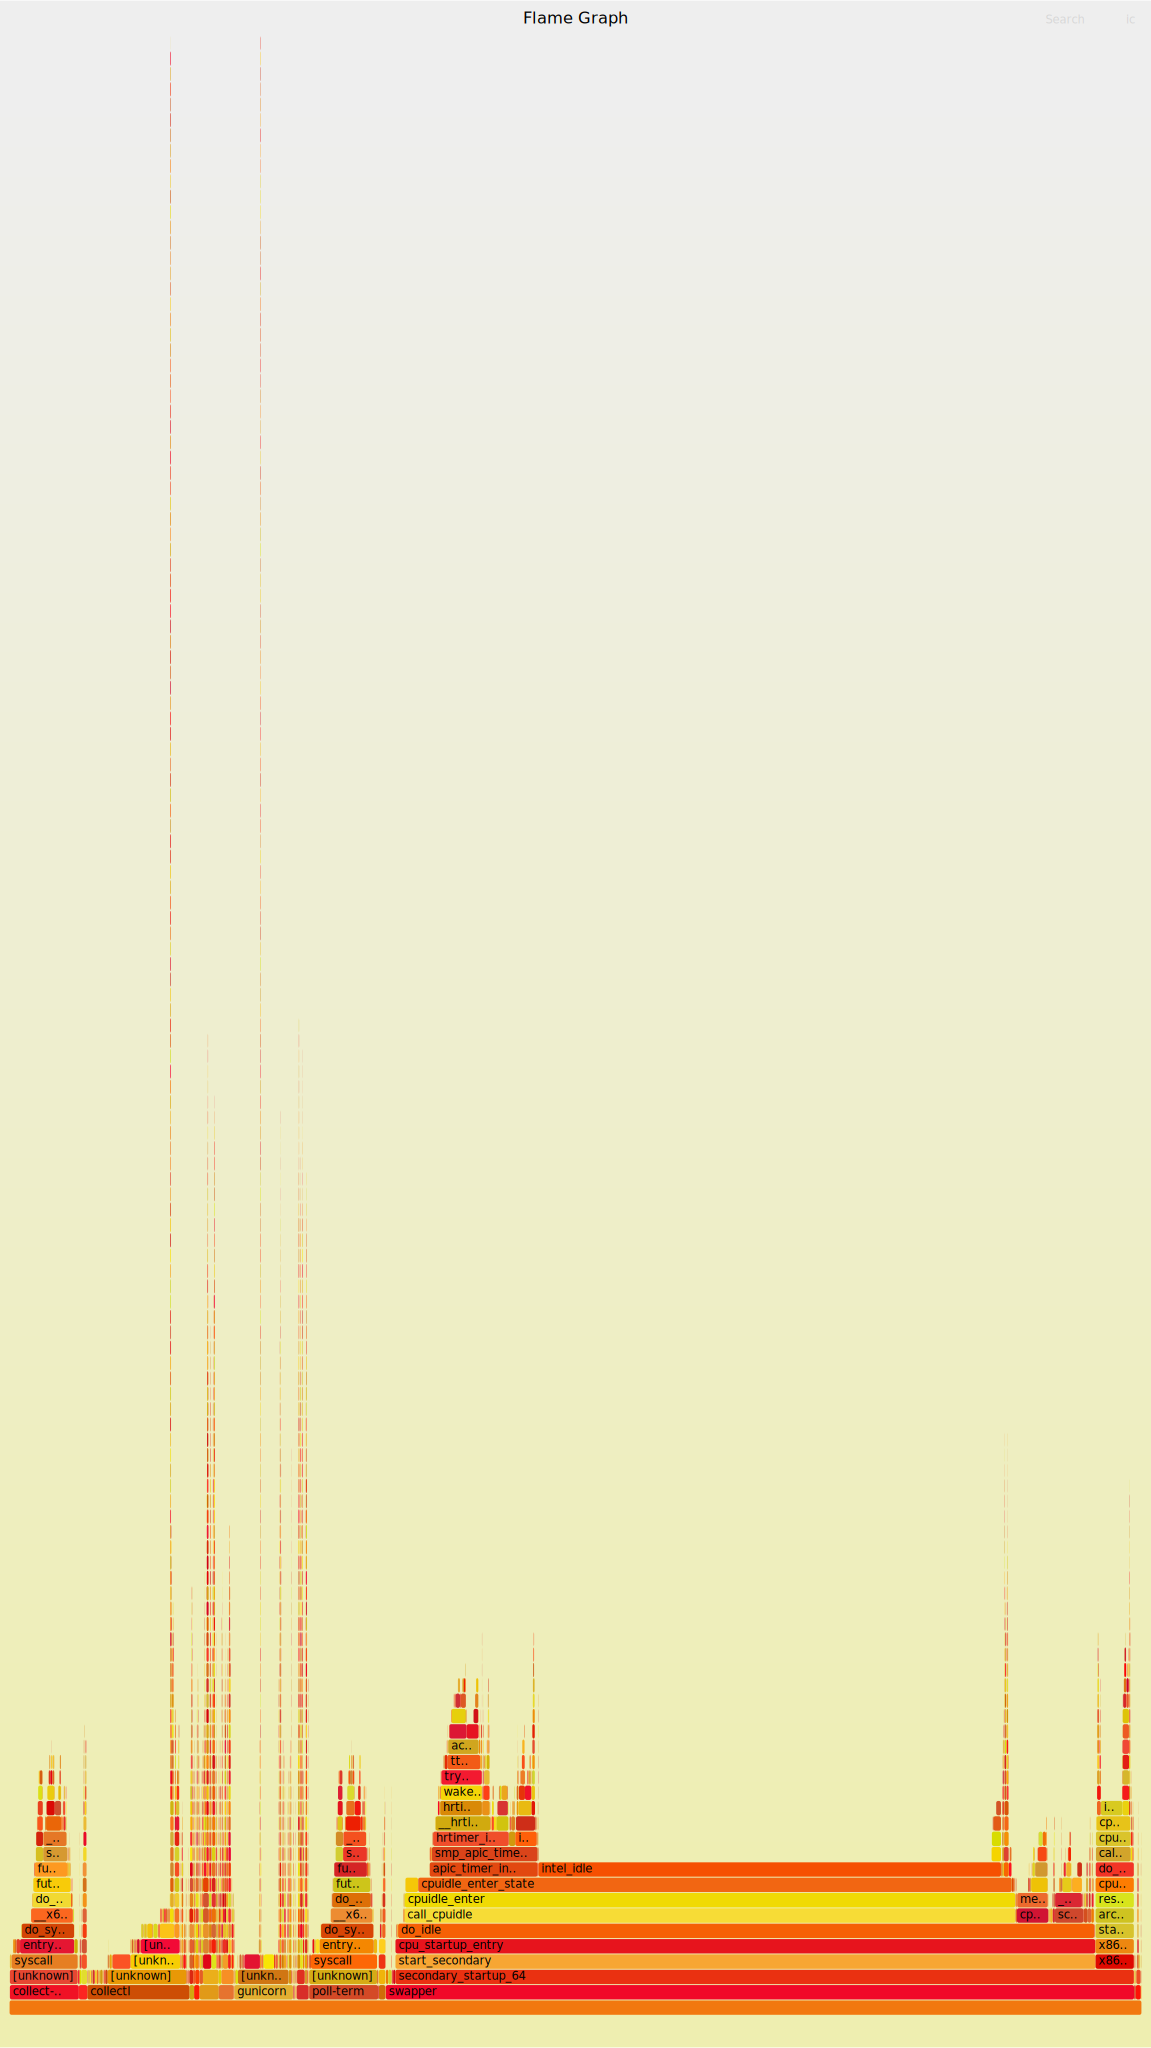



 FLAME GRAPH FOR NODE pc796.emulab.net




In [9]:
from IPython.display import SVG, display
for node_hostname, node_conf in system_conf.items():
    for monitor_name in node_conf.get("monitors", {}):
        if "perf" in monitor_name:
            display(SVG(filename = "{input}/{host}.svg".format(input = os.path.join(EXPERIMENT_DIR, "logs", node_hostname, monitor_name.replace(' ', '_') ), host = node_hostname)))
            print(f"\n\n FLAME GRAPH FOR NODE {node_hostname}\n\n")